In [1]:
import pandas as pd


import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

/Users/miksx/.pyenv/versions/3.11.4/envs/TDT4173/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Data handling
import pandas as pd

# Helper functions
from manual.functions import get_days_sinse_beginning_of_year, get_hours_of_day, remove_consecutive_measurments

# Types handling
import numpy as np

# Data science
from sklearn.preprocessing import MinMaxScaler

# Feature engineering
from feature_engine.selection import DropCorrelatedFeatures, DropConstantFeatures
from feature_engine.timeseries.forecasting import LagFeatures

non_equal_value_columns = [
    "dew_or_rime:idx",
    "dew_point_2m:K",
    "elevation:m",
    "fresh_snow_12h:cm",
    "fresh_snow_1h:cm",
    "fresh_snow_24h:cm",
    "fresh_snow_3h:cm",
    "fresh_snow_6h:cm",
    "is_day:idx",  # A and B
    "is_in_shadow:idx",  # A and B
    "precip_5min:mm",  # C and B
    "precip_type_5min:idx",  # A and B
    "prob_rime:p",
    "snow_depth:cm",
    "snow_melt_10min:mm",
    "wind_speed_w_1000hPa:ms",  # A and B
]


class MasterDataframes:
    df_a: pd.DataFrame = None
    df_b: pd.DataFrame = None
    df_c: pd.DataFrame = None

    X_scaler: MinMaxScaler = None
    Y_scaler: MinMaxScaler = None

    # def __init__(self):
    #     self.df_a = self.prep_dataset_x(X_train_observed_a, Y_train_observed_a)
    #     self.df_b = self.prep_dataset_x(X_train_observed_b, Y_train_observed_b)
    #     self.df_c = self.prep_dataset_x(X_train_observed_c, Y_train_observed_c)

    def prep_dataset(self, location: str, merge_dfs: bool = False):
        if location == "A":
            Y_train_x = Y_train_observed_a
            X_train_observed_x = X_train_observed_a
            X_train_estimated_x = X_train_estimated_a
        if location == "B":
            X_train_observed_x = X_train_observed_b
            Y_train_x = Y_train_observed_b
            X_train_estimated_x = X_train_estimated_b
        if location == "C":
            X_train_observed_x = X_train_observed_c
            Y_train_x = Y_train_observed_c
            X_train_estimated_x = X_train_estimated_c

        if merge_dfs:
            X_train_total_a = pd.concat([X_train_observed_a, X_train_estimated_a]).reset_index()
            X_train_total_b = pd.concat([X_train_observed_b, X_train_estimated_b]).reset_index()
            X_train_total_c = pd.concat([X_train_observed_c, X_train_estimated_c]).reset_index()

            if location != "A":
                X_train_total_a = X_train_total_a.drop(columns=non_equal_value_columns)
            if location != "B":
                X_train_total_b = X_train_total_b.drop(columns=non_equal_value_columns)
            if location != "C":
                X_train_total_c = X_train_total_c.drop(columns=non_equal_value_columns)
            X_train_total = pd.merge(
                pd.merge(
                    X_train_total_a,
                    X_train_total_b,
                    on="date_forecast",
                    how="inner",
                    suffixes=("_a", "_b"),
                ),
                X_train_total_c,
                on="date_forecast",
                how="inner",
                suffixes=("", "_c"),
            )
        else:
            X_train_total = pd.concat([X_train_observed_x, X_train_estimated_x]).reset_index()
        return X_train_total, Y_train_x

    def prep_dataset_x_y(self, location: str, drop_features=False, merge_dfs=False) -> pd.DataFrame:
        X_train_total, Y_train_total = self.prep_dataset(location, merge_dfs)

        # X_train_group = X_train_total.groupby(pd.Grouper(key="date_forecast", freq="1H")).mean().reset_index()
        X_train_group = X_train_total.groupby(pd.Grouper(key="date_forecast", freq="1H")).first().reset_index()
        X_train_group.rename(columns={"date_forecast": "time"}, inplace=True)
        X_train_group.drop(columns=["date_calc"], inplace=True)
        X_train_group.drop(columns=[c for c in X_train_group.columns if "index" in c], inplace=True)

        inner_merge = pd.merge(X_train_group, Y_train_total, on="time", how="inner")
        id_columns = [c for c in inner_merge.columns if ":idx" in c]

        filled = self._fill_df(inner_merge, id_columns)
        df_new_features = self._add_features_full_df(filled)
        cleaned_df = self._clean_df(df_new_features)
        drop_consecutive_pv_zeros = remove_consecutive_measurments(cleaned_df)

        X = drop_consecutive_pv_zeros.drop(columns=["pv_measurement"]).astype("float")
        # X = self._add_lag_features(X, drop_features=drop_features)

        Y = drop_consecutive_pv_zeros["pv_measurement"].fillna(0).reset_index(drop=True)

        # X_scaled, Y_scaled = self._scale_and_create_scaler(X, Y)
        # return X_scaled, Y_scaled
        return X, Y

    def _scale_and_create_scaler(self, X: pd.DataFrame, Y: pd.Series):
        self.Y_scaler = MinMaxScaler(feature_range=(0, 1)).fit(Y.values.reshape(-1, 1))
        self.X_scaler = MinMaxScaler(feature_range=(0, 1)).fit(X)

        X_scaled = self.X_scaler.transform(X)
        Y_scaled = self.Y_scaler.transform(Y.values(-1, 1))

        df_X = pd.DataFrame(X_scaled, columns=X.columns)
        s_Y = pd.Series(Y_scaled.ravel(), name=Y.name).reset_index(drop=True)

        return df_X, s_Y

    def _add_features_full_df(self, df: pd.DataFrame) -> pd.DataFrame:
        df["year"] = df["time"].apply(lambda datestring: np.datetime64(datestring).astype(pd.Timestamp).year)
        df["month"] = df["time"].apply(lambda datestring: np.datetime64(datestring).astype(pd.Timestamp).month)
        df["hours"] = df["time"].apply(lambda datestring: get_hours_of_day(datestring))
        df["since_jan_1"] = df["time"].apply(lambda datestring: get_days_sinse_beginning_of_year(datestring))

        df["effective_energy"] = df["clear_sky_rad:W"] * (df["total_cloud_cover:p"] / 100)

        return df

    def _add_lag_features(self, X: pd.DataFrame, drop_features: bool = False) -> pd.DataFrame:
        no_nan_columns_df = X[[c for c in X.columns if len(X[X[c].isna()].index) == 0]]
        no_nan_columns_df = no_nan_columns_df.select_dtypes(include=["number", "float", "int"])
        no_nan_columns = no_nan_columns_df[~no_nan_columns_df.isna()].columns.to_list()

        lag_f = LagFeatures(variables=no_nan_columns, periods=1)

        X_tr = lag_f.fit_transform(no_nan_columns_df)
        X[X_tr.columns] = X_tr

        if drop_features:
            tr = DropCorrelatedFeatures(variables=None, method="pearson", threshold=0.8)
            Xdc = tr.fit_transform(X)

            transformer = DropConstantFeatures(tol=0.7, missing_values="ignore")
            X = transformer.fit_transform(Xdc)

        return X

    def _fill_df(self, df: pd.DataFrame, categorical_columns: list) -> pd.DataFrame:
        inner_to_split = df.copy()
        # non_id_columns = [c for c in inner_to_split.columns if ":idx" not in c]

        inner_to_split[categorical_columns].fillna(0, inplace=True)
        # inner_to_split[non_id_columns].fillna(method="bfill", inplace=True)

        return inner_to_split

    def _clean_df(self, df: pd.DataFrame) -> pd.DataFrame:
        df.drop(columns=[c for c in df.columns if "date" in c or "tim" in c], inplace=True)
        df = df.astype("float")

        # non_categorical = [c for c in df.columns if ":idx" not in c]

        # lower_bound = df[non_categorical].quantile(0.05)
        # upper_bound = df[non_categorical].quantile(0.95)

        # df[non_categorical] = df[(df[non_categorical] >= lower_bound) & (df[non_categorical] <= upper_bound)]

        return df

    def _shorten_dataset_to_prediction_scale(self, df: pd.DataFrame, location: str) -> pd.DataFrame:
        test_df["time_merge"] = pd.to_datetime(test_df["time"])
        df["time_merge"] = pd.to_datetime(df["time"])
        test_mapped = test_df.loc[test_df["location"] == location]

        train_mapped = df.merge(
            test_mapped[["time", "time_merge"]], how="left", on="time_merge", suffixes=("_train", "_test")
        ).reset_index(drop=True)

        df_c = train_mapped[train_mapped["time_test"].notna()]

        df_c = df_c.drop(columns=[c for c in df_c.columns if "tim" in c or "date" in c])
        df_c = df_c.astype("float")

        return df_c

    def prep_test(self, location: str, merge_dfs=False) -> pd.DataFrame:
        if merge_dfs:
            X_test_a = X_test_estimated_a
            X_test_b = X_test_estimated_b
            X_test_c = X_test_estimated_c
            if location != "A":
                X_test_a = X_test_a.drop(columns=non_equal_value_columns)
            if location != "B":
                X_test_b = X_test_b.drop(columns=non_equal_value_columns)
            if location != "C":
                X_test_c = X_test_c.drop(columns=non_equal_value_columns)
            df = pd.merge(
                pd.merge(
                    X_test_a,
                    X_test_b,
                    on="date_forecast",
                    how="inner",
                    suffixes=("_a", "_b"),
                ),
                X_test_c,
                on="date_forecast",
                how="inner",
                suffixes=("", "_c"),
            )
        else:
            if location == "A":
                df = X_test_estimated_a
            if location == "B":
                df = X_test_estimated_b
            if location == "C":
                df = X_test_estimated_c

        df.rename(columns={"date_forecast": "time"}, inplace=True)

        categorical = [c for c in df.columns if ":idx" in c]
        filled = self._fill_df(df, categorical)

        df_new_features = self._add_features_full_df(filled)
        # df_with_lag = self._add_lag_features(df_new_features)
        df_shortened = self._shorten_dataset_to_prediction_scale(df_new_features, location)

        print(f"Location {location}. length: {str(len(df_new_features))}")

        return df_shortened


# Estimate
X_train_estimated_a = pd.read_parquet("../A/X_train_estimated.parquet")
X_train_estimated_b = pd.read_parquet("../B/X_train_estimated.parquet")
X_train_estimated_c = pd.read_parquet("../C/X_train_estimated.parquet")

# Test estimates
X_test_estimated_a = pd.read_parquet("../A/X_test_estimated.parquet")
X_test_estimated_b = pd.read_parquet("../B/X_test_estimated.parquet")
X_test_estimated_c = pd.read_parquet("../C/X_test_estimated.parquet")

# Full test estimate
X_test_A = pd.read_parquet("../A/X_test_A.parquet")
X_test_B = pd.read_parquet("../B/X_test_B.parquet")
X_test_C = pd.read_parquet("../C/X_test_C.parquet")

test_df = pd.read_csv("../test.csv")

# Observations
X_train_observed_a = pd.read_parquet("../A/X_train_observed.parquet")
X_train_observed_b = pd.read_parquet("../B/X_train_observed.parquet")
X_train_observed_c = pd.read_parquet("../C/X_train_observed.parquet")

# Targets
Y_train_observed_a = pd.read_parquet("../A/train_targets.parquet")
Y_train_observed_b = pd.read_parquet("../B/train_targets.parquet")
Y_train_observed_c = pd.read_parquet("../C/train_targets.parquet")


# Training A

In [3]:
trials=3
submission="seventeenth"

In [ ]:
# Data handling
import pickle
import json
from classes.DataFrameHandler import MasterDataframes

# Data science
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Optimization / feature engineering tools
from classes.ModelObjectives import XGBRCVObjective  # , HGBRObjective, RFRObjective, XGBRObjective

from classes.Models import MonoModel


class MonoModelTrainer:
    modelA = None
    modelB = None
    modelC = None

    M_df = MasterDataframes()

    def train_model(self, trials: int, location: str, drop_features=True, merge_dfs=False):
        X, Y = self.M_df.prep_dataset_x_y(location, merge_dfs=merge_dfs)
        scaler_x = MinMaxScaler()
        scaler_y = MinMaxScaler()

        X = scaler_x.fit_transform(X)
        Y = scaler_y.fit_transform(Y.to_numpy().reshape(-1, 1)).flatten()

        X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=10, test_size=0.20)

        model, selection_model, study, selection, select_X_test = XGBRCVObjective(
            X_train, X_test, y_train, y_test, trials
        )

        if selection_model:
            y_pred = selection_model.predict(select_X_test)
        else:
            y_pred = model.predict(X_test)

        M_df_c = self.M_df
        switched_model = MonoModel(
            model=model,
            selection_model=selection_model,
            M_df=M_df_c,
            y_pred=y_pred,
            y_test=y_test,
            X_test=X_test,
            X_train=X_train,
            params=study.best_params,
            scaler_x=scaler_x,
            scaler_y=scaler_y,
            selection=selection,
        )
        if location == "A":
            self.modelA = switched_model
        if location == "B":
            self.modelB = switched_model
        if location == "C":
            self.modelC = switched_model

        MAE = mean_absolute_error(y_test, y_pred)

        filename = f"models/{location}_xgb_MAE_{str(int(MAE))}.pkl"
        model_params = f"models/{location}_xgb_MAE_{str(int(MAE))}_best_params.json"
        with open(model_params, "w") as f:
            f.write(json.dumps(study.best_params, indent=4))
        f.close()
        pickle.dump(model, open(filename, "wb"))

        print("R2: ", r2_score(y_test, y_pred))
        print("RMSE: ", mean_squared_error(y_test, y_pred, squared=False))
        print("graded! MAE: ", MAE)
        print("Best params: " + json.dumps(study.best_params, indent=4))

        return switched_model


In [4]:
model_a = MonoModelTrainer().train_model(location="A", trials=trials)

[I 2023-10-17 04:14:34,383] A new study created in memory with name: regression
[I 2023-10-17 04:14:37,576] Trial 1 finished with value: 0.061713982506785954 and parameters: {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'tree_method': 'hist', 'max_depth': 4, 'learning_rate': 0.7413274004991911, 'n_estimators': 540, 'min_child_weight': 5, 'gamma': 0.9995448459397365, 'subsample': 0.7, 'colsample_bytree': 0.8, 'reg_alpha': 0.8710675419792644, 'reg_lambda': 0.1800903413606064, 'random_state': 665}. Best is trial 1 with value: 0.061713982506785954.
[I 2023-10-17 04:14:38,243] Trial 2 finished with value: 0.11223620603180337 and parameters: {'objective': 'reg:squarederror', 'eval_metric': 'mae', 'tree_method': 'hist', 'max_depth': 10, 'learning_rate': 0.2505251812592975, 'n_estimators': 437, 'min_child_weight': 4, 'gamma': 0.6513851442510924, 'subsample': 0.7, 'colsample_bytree': 1.0, 'reg_alpha': 0.8926720878570209, 'reg_lambda': 0.661216247039005, 'random_state': 857}. Best is t

R2:  0.8237395297855098
RMSE:  0.0835797785689038
graded! MAE:  0.044947758639202126
Best params: {
    "objective": "reg:squarederror",
    "eval_metric": "mae",
    "tree_method": "hist",
    "max_depth": 7,
    "learning_rate": 0.9133856350192731,
    "n_estimators": 641,
    "min_child_weight": 3,
    "gamma": 0.1964126724766476,
    "subsample": 0.85,
    "colsample_bytree": 0.75,
    "reg_alpha": 0.6792775750159704,
    "reg_lambda": 0.4753514754925571,
    "random_state": 164
}


In [5]:
# model_a.plot_important_features(top=30)

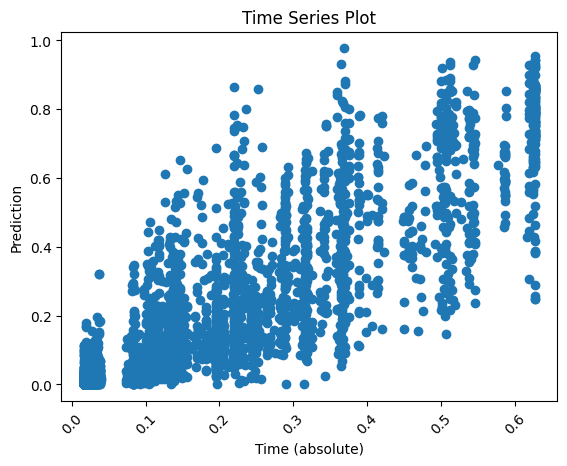

In [6]:
model_a.plot_pred_vs_test()

# Train B

In [7]:
model_b = MonoModelTrainer().train_model(location="B", merge_dfs=True, trials=trials)

KeyboardInterrupt: 

In [ ]:
# model_b.plot_important_features(50)

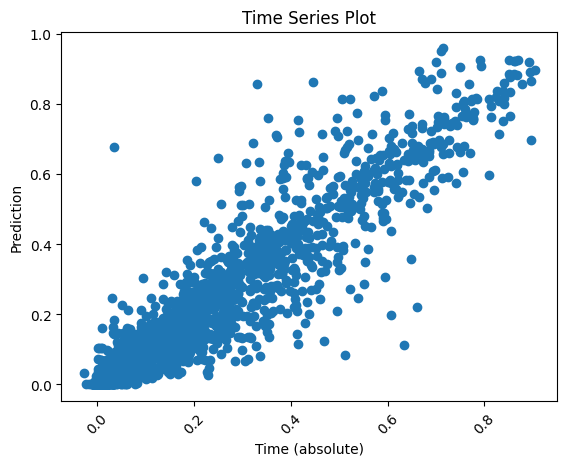

In [ ]:
model_b.plot_pred_vs_test()

# Train c

In [ ]:
model_c = MonoModelTrainer().train_model(location="C", merge_dfs=True, trials=trials)

[I 2023-10-06 22:13:27,069] A new study created in memory with name: regression
[I 2023-10-06 22:13:27,816] Trial 5 finished with value: 0.08401975025328665 and parameters: {'max_leaf_nodes': 22, 'learning_rate': 0.3968091743705049, 'max_depth': 13, 'min_samples_leaf': 22, 'max_bins': 50}. Best is trial 5 with value: 0.08401975025328665.
[I 2023-10-06 22:13:27,839] Trial 4 finished with value: 0.08401975025328665 and parameters: {'max_leaf_nodes': 15, 'learning_rate': 0.39151399250698865, 'max_depth': 13, 'min_samples_leaf': 22, 'max_bins': 76}. Best is trial 5 with value: 0.08401975025328665.
[I 2023-10-06 22:13:27,847] Trial 1 finished with value: 0.08401975025328665 and parameters: {'max_leaf_nodes': 13, 'learning_rate': 0.20861154418276784, 'max_depth': 12, 'min_samples_leaf': 26, 'max_bins': 104}. Best is trial 5 with value: 0.08401975025328665.
[I 2023-10-06 22:13:27,849] Trial 2 finished with value: 0.08401975025328665 and parameters: {'max_leaf_nodes': 29, 'learning_rate': 0.25

R2:  0.9054459365423837
RMSE:  0.05298089406936807
graded! MAE:  0.02401484762661578
Best params: {
    "max_leaf_nodes": 22,
    "learning_rate": 0.3968091743705049,
    "max_depth": 13,
    "min_samples_leaf": 22,
    "max_bins": 50
}


In [ ]:
# model_c.plot_important_features(30)

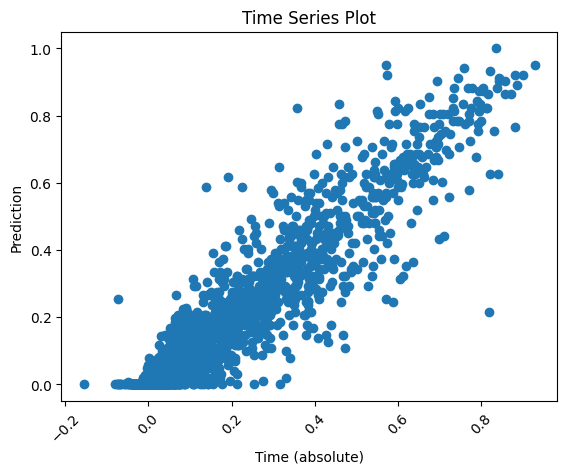

In [ ]:
model_c.plot_pred_vs_test()

# Create prediction

In [ ]:
y_pred_a = model_a.predict_test_data("A", merge_df=True)
print("Length pred: ", len(y_pred_a))
y_pred_b = model_b.predict_test_data("B", merge_df=True)
print("Length pred: ", len(y_pred_b))
y_pred_c = model_c.predict_test_data("C", merge_df=True)
print("Length pred: ", len(y_pred_c))

predictions = list(y_pred_a) + list(y_pred_b) + list(y_pred_c)

Location A. length: 2880
Length pred:  720
Location B. length: 2880
Length pred:  720
Location C. length: 2880
Length pred:  720


In [ ]:
compare_best = pd.read_csv("submissions/best_prediction.csv")["prediction"]

In [ ]:
print("MAE: "+ str(mean_absolute_error(compare_best, predictions)))

MAE: 97.6489528026221


In [ ]:
len(predictions)

2160

In [ ]:
df = pd.DataFrame({"prediction":predictions}).rename_axis(index="id")
df.to_csv(f"submissions/{submission}_submission.csv")

# Predict from pickle_file

In [ ]:
# model_a_pickle = pickle.load(open("models/A_xgb_MAE_172_.pkl", "rb"))

In [ ]:
# pickle_model = MLModel(model_a_pickle)

In [ ]:
# pickle_model.predict_test_data("A")